<a href="https://colab.research.google.com/github/ProfAI/machine-learning-fondamenti/blob/main/Progetto%20Finale%20-%20Cross%20Selling%20di%20Polizze/health_insurance_cross_sell_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:
- **id**: id univoco dell'acquirente.
- **Gender**: sesso dell'acquirente.
- **Age**: età dell'acquirente.
- **Driving_License**: 1 se l'utente ha la patente di guida, 0 altrimenti.
- **Region_Code**: codice univoco della regione dell'acquirente.
- **Previously_Insured**: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.
- **Vehicle_Age**: età del veicolo
- **Vehicle_Damage**: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
- **Annual_Premium**: la cifra che l'utente deve pagare come premio durante l'anno.
- **Policy_Sales_Channel**: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)
- **Vintage**: numero di giorni dalla quale l'utente è cliente dell'azienda.
- **Response**: 1 se l'acquirente ha risposto positivametne alla proposta di vendità, 0 altrimenti.

L'obiettivo del modello è prevedere il valore di **Response**.

**Tip**
Fai attenzione alla distribuzione delle classi, dai uno sguardo a [questo approfondimento](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). In caso di classi sbilanciate puoi provare a:

- Penalizzare la classe più frequente (ricorda l'argomento class_weight)
- Utilizzare [l'oversampling o l'undersampling](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/).


[LINK AL DATASET (Richiede un'account su Kaggle)](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction)

Per prevedere in modo accurato il valore id Response è stato selezioato il miglior modello di regressione logistica confrontando diverse configurazioni con differenti metodi di bilanciamento delle classi. La metrica scelta per considerare il miglior modello è stata la recall.
Nel contesto del cross-selling di assicurazioni, dove l'accuratezza può essere poco informativa a causa dello squilibrio delle classi (nonostante si adotteranno tecniche di bilanciamento), è più utile concentrarsi sulle altre metriche.

La metrica considerata più rilevante è la Recall. Infatti l'azienda potrebbe voler massimizzare il numero totale di clienti potenzialmente interessati che vengono contattati. In questo caso, anche se il modello può includere alcuni clienti non realmente interessati, è importante non perdere alcuna opportunità di vendita. Inoltre con procedure automatizzate in ambito di vendita (e.g. mail automatiche ai potenziali clienti), la presenza di falsi positivi non crea problemi rilevanti.


Il codice si articola nelle seguenti sezioni:
- import librerie per l'analisi 
- import del dataset e data quality per rimozione colonne, duplicati e valori nulli 
- one hot encoding e label encoding per preparare il dataset 
- train test split pdf completare la preparazione della base dati (rimuovendo un piccola parte per fare il test di previsione out of sample)
- funzione per addestrare il modello e calcolare le metriche rilevanti (fun_logistic_regression)
- selezione del modello con valore più basso di recall
- previsione finale di Response

In [228]:
import pandas as pd
from getpass import getuser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import RocCurveDisplay
from collections import Counter

RANDOM_SEED = 0


In [229]:
user = getuser()
DATASET_PATH = r"C:\Users\\" +user+ r"\OneDrive\My Drive\OneDrive\Desktop\CorsoChatbot\ProfessionAI_ML_1\Progetto Finale - Cross Selling di Polizze\insurance_cross_sell.csv"
df = pd.read_csv(DATASET_PATH)
df.columns



Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [230]:
#Data Quality e conteggio delle classi
df = df.drop_duplicates()
df = df.drop(columns=['id'])
counts = df["Response"].value_counts()
null_counts = df.isnull().sum()
print(null_counts)
print(f"Negative_Response = {counts[0]} ({counts[0]/counts.sum()*100:.2f}%) ")
print(f"Positive_Response = {counts[1]} ({counts[1]/counts.sum()*100:.2f}%) ")


Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64
Negative_Response = 334399 (87.74%) 
Positive_Response = 46710 (12.26%) 


In [231]:
#Funzione per trasformare in valori numerici le variabili binomiali e le classi presenti nel dataset
def apply_mapping(df, column_mapping_dict):
    """
    Applica una mappatura a specifiche colonne del DataFrame.

    Parametri:
    df (pd.DataFrame): Il DataFrame contenente le colonne su cui applicare la mappatura.
    column_mapping_dict (dict): Un dizionario in cui le chiavi sono i nomi delle colonne e i valori sono i dizionari di mappatura.

    Restituisce:
    pd.DataFrame: Il DataFrame con le colonne specificate mappate.
    """
    for column, mapping in column_mapping_dict.items():
        df[column] = df[column].map(mapping)
    return df

# df.Vehicle_Age.value_counts() 

column_mapping_dict = {
    "Gender": {"Male": 1, "Female": 0},
    "Vehicle_Damage": {"Yes": 1, "No": 0},
    "Vehicle_Age": {"< 1 Year":0,  "1-2 Year":1, "> 2 Years":2}
}

#Applica mapping
df = apply_mapping(df, column_mapping_dict)
df.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


In [232]:
#Divisione in train, validation e test del dataset (rispettivamente saranno chiamati train, test, test_out_of_sample)
X = df.drop(columns=["Response"])
y = df["Response"]
X_temp, X_test_out_of_sample, y_temp, y_test_out_of_sample = train_test_split(X, y, test_size=0.0001, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=RANDOM_SEED)


In [233]:
X_test_out_of_sample

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
220145,0,24,1,8.0,1,0,0,38744.0,152.0,267
194704,0,41,1,28.0,0,1,1,24929.0,124.0,156
203625,0,72,1,8.0,0,1,1,113486.0,26.0,70
218048,1,43,1,47.0,0,2,1,2630.0,156.0,209
230458,1,25,1,41.0,1,0,1,62383.0,160.0,20
115334,1,38,1,47.0,0,1,1,31420.0,26.0,153
155444,1,48,1,28.0,0,2,1,45161.0,122.0,267
57192,0,50,1,28.0,0,1,1,54426.0,26.0,117
289488,0,46,1,15.0,0,1,0,2630.0,152.0,223
96039,1,21,1,33.0,0,1,0,21965.0,154.0,175


No transformation:
TRAIN REPORT
PRECISION: 0.35874439461883406
RECALL: 0.002450454865684443
F1: 0.004867660480681472
ACCURACY: 0.8773753603574896
TEST REPORT
PRECISION: 0.36231884057971014
RECALL: 0.0017784733584690902
F1: 0.003539572419651706
ACCURACY: 0.8768730154564778


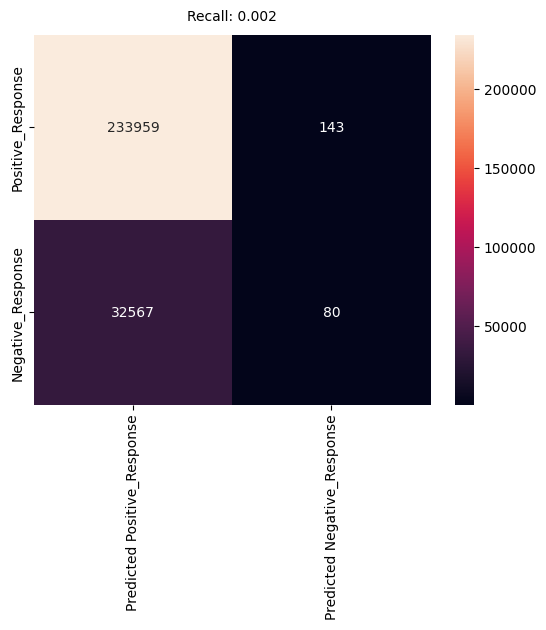

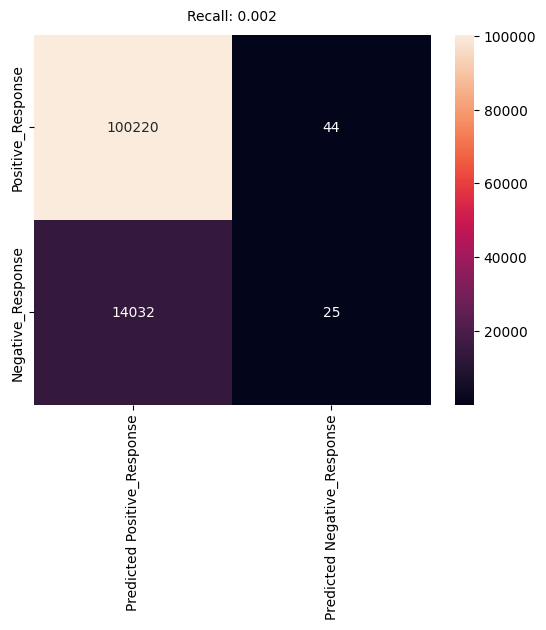

AUC Score (Train): 0.8324
AUC Score (Test): 0.8312
----------------------------------------------------------------------------------------------
Class weight:
TRAIN REPORT
PRECISION: 0.2503341142434867
RECALL: 0.9753729285998713
F1: 0.3984135027432139
ACCURACY: 0.6395000543582169
TEST REPORT
PRECISION: 0.2508820357201616
RECALL: 0.9763107348651917
F1: 0.3991855730075625
ACCURACY: 0.63863157250199


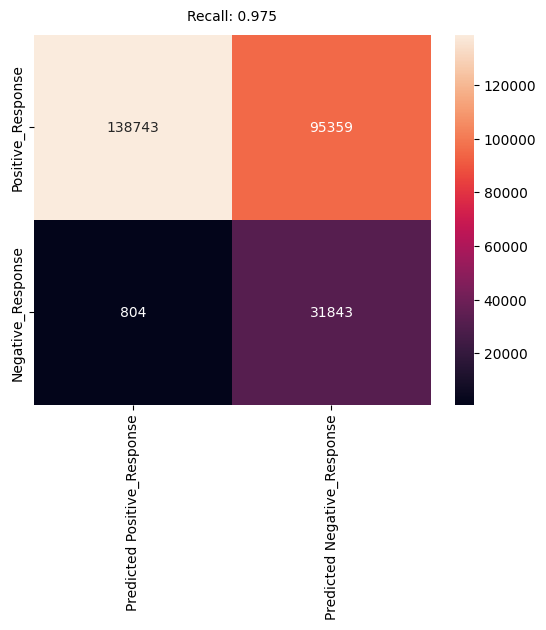

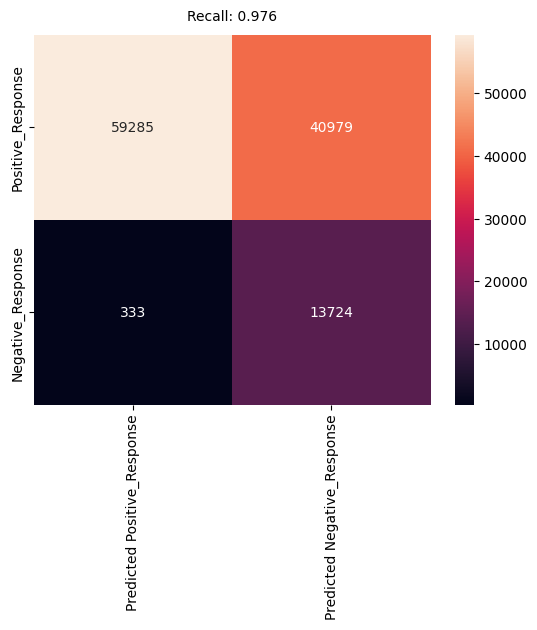

AUC Score (Train): 0.8325
AUC Score (Test): 0.8312
----------------------------------------------------------------------------------------------
Oversampling Ratio 1:
After SMOTE: Counter({0: 234102, 1: 234102})
TRAIN REPORT
PRECISION: 0.7055289204117189
RECALL: 0.9756046509641096
F1: 0.8188728223183906
ACCURACY: 0.7842051755217812
TEST REPORT
PRECISION: 0.2508824228680115
RECALL: 0.9758839012591591
F1: 0.3991503724394786
ACCURACY: 0.6387365400932462


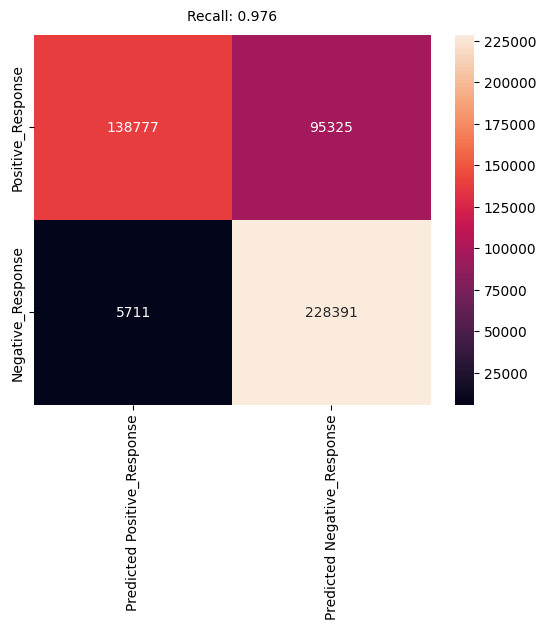

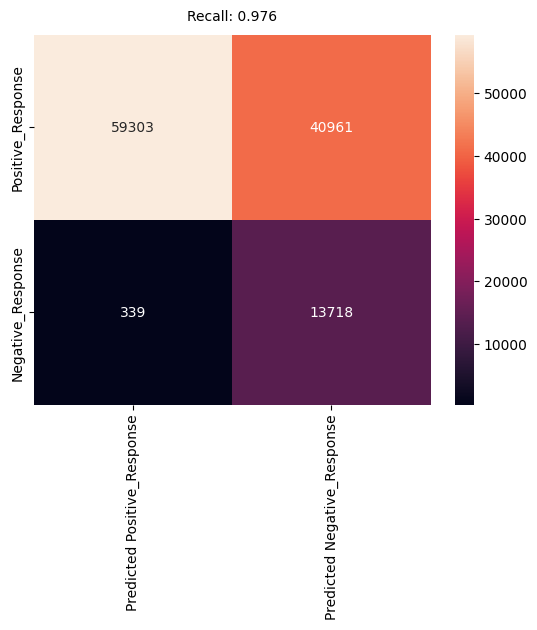

AUC Score (Train): 0.8331
AUC Score (Test): 0.8312
----------------------------------------------------------------------------------------------
Undersampling Ratio 1:
After undersample: Counter({0: 32647, 1: 32647})
TRAIN REPORT
PRECISION: 0.7057181469747658
RECALL: 0.975709866143903
F1: 0.8190373341561247
ACCURACY: 0.7844212331914111
TEST REPORT
PRECISION: 0.2508726721128717
RECALL: 0.976524151668208
F1: 0.39919155494809083
ACCURACY: 0.6385615941078192


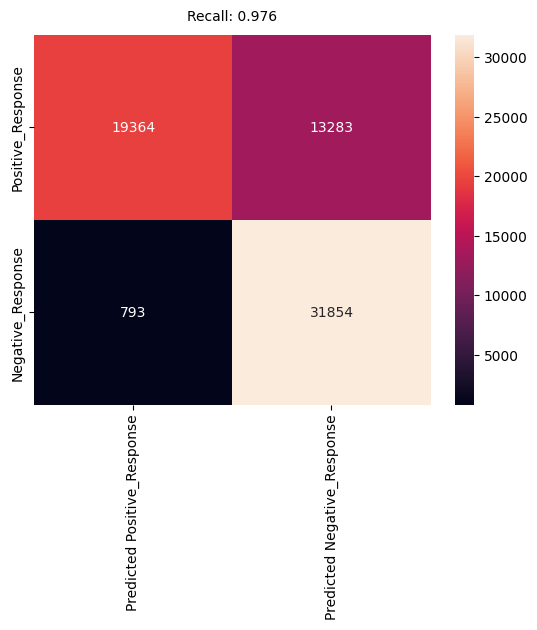

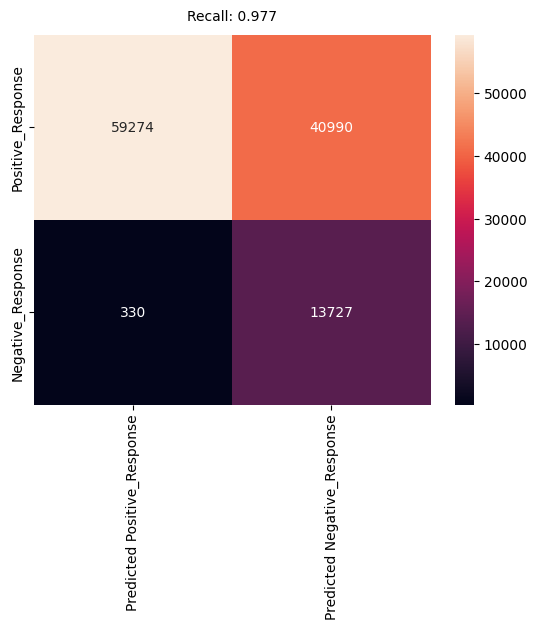

AUC Score (Train): 0.8315
AUC Score (Test): 0.8309
----------------------------------------------------------------------------------------------
Oversampling Ratio 0.5:
After SMOTE: Counter({0: 234102, 1: 117051})
TRAIN REPORT
PRECISION: 0.6103758342114507
RECALL: 0.7423003647982503
F1: 0.6699048962802766
ACCURACY: 0.7561547245787449
TEST REPORT
PRECISION: 0.30264615025936936
RECALL: 0.73877783310806
F1: 0.42938951024374117
ACCURACY: 0.7585657928114694


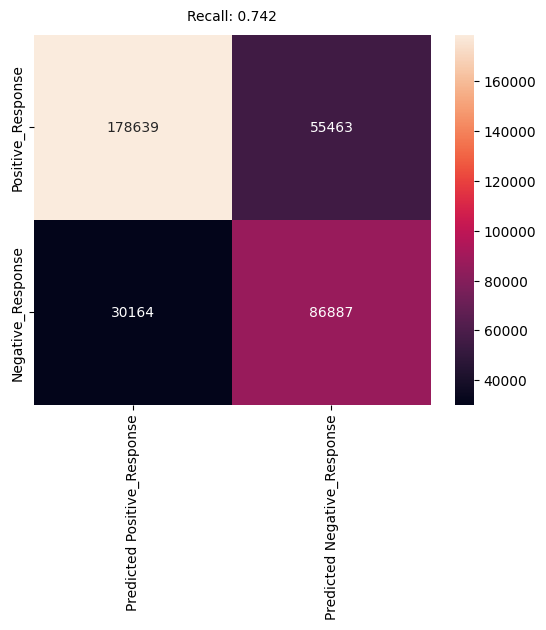

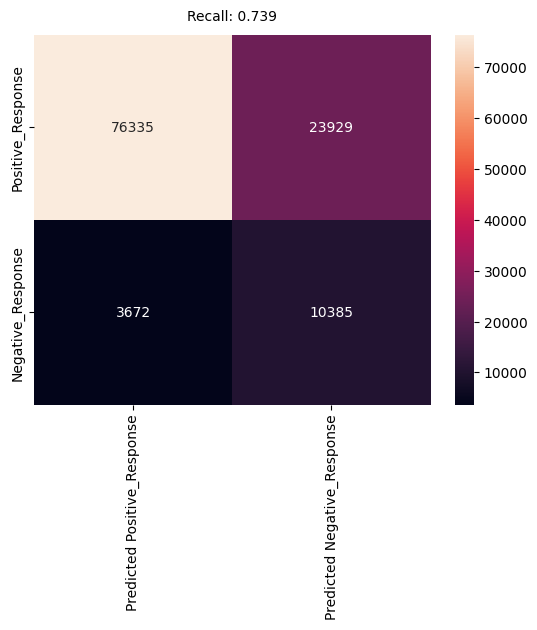

AUC Score (Train): 0.8328
AUC Score (Test): 0.8312
----------------------------------------------------------------------------------------------
Undersampling Ratio 0.5:
After undersample: Counter({0: 65294, 1: 32647})
TRAIN REPORT
PRECISION: 0.6066016244057052
RECALL: 0.7503599105583973
F1: 0.670865796716463
ACCURACY: 0.7545767349730961
TEST REPORT
PRECISION: 0.3014199594297306
RECALL: 0.750515757273956
F1: 0.4301031432182315
ACCURACY: 0.7554430069715975


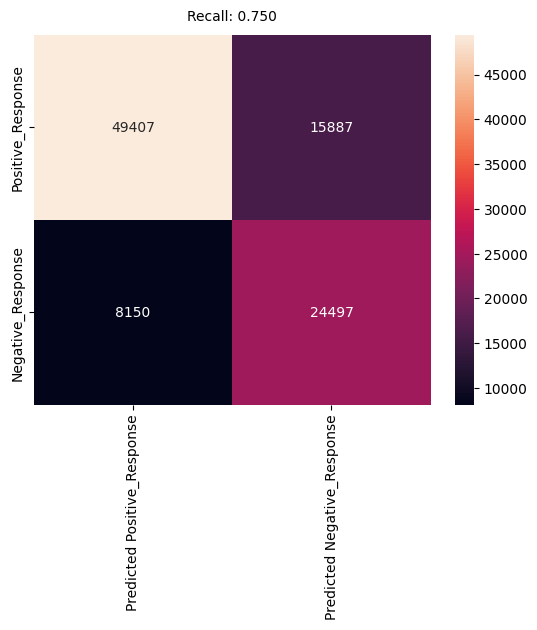

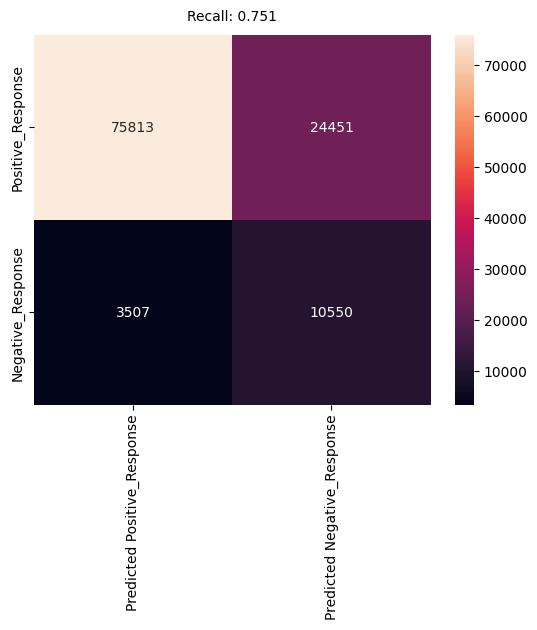

AUC Score (Train): 0.8324
AUC Score (Test): 0.8311
----------------------------------------------------------------------------------------------
Oversampling Ratio 0.75:
After SMOTE: Counter({0: 234102, 1: 175576})
TRAIN REPORT
PRECISION: 0.6456660156927094
RECALL: 0.9546976807764159
F1: 0.7703447023923049
ACCURACY: 0.7560449914322956
TEST REPORT
PRECISION: 0.2527466293515875
RECALL: 0.9508429963719144
F1: 0.3993426949507021
ACCURACY: 0.6482885908975604


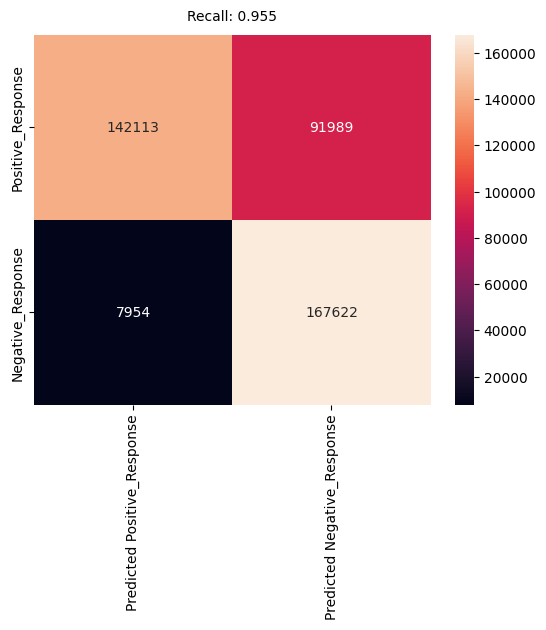

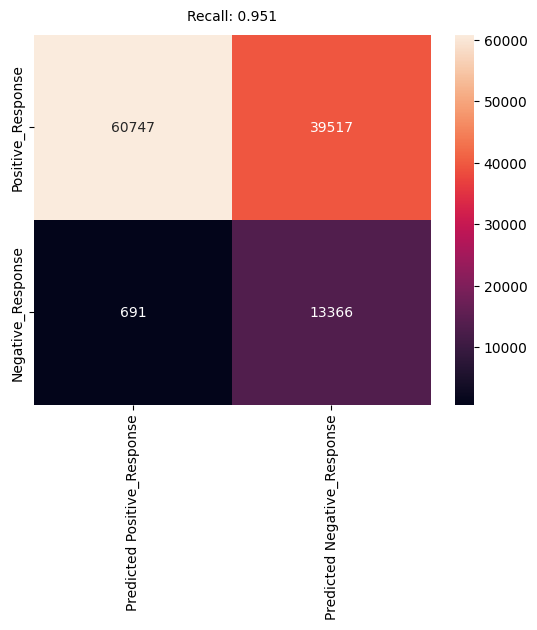

AUC Score (Train): 0.8330
AUC Score (Test): 0.8312
----------------------------------------------------------------------------------------------
Undersampling Ratio 0.75:
After undersample: Counter({0: 43529, 1: 32647})
TRAIN REPORT
PRECISION: 0.6445524971155431
RECALL: 0.9582503752259013
F1: 0.7707032260448615
ACCURACY: 0.7556316950220542
TEST REPORT
PRECISION: 0.25216397496908605
RECALL: 0.9574589172654193
F1: 0.39919324939567846
ACCURACY: 0.6456206646197986


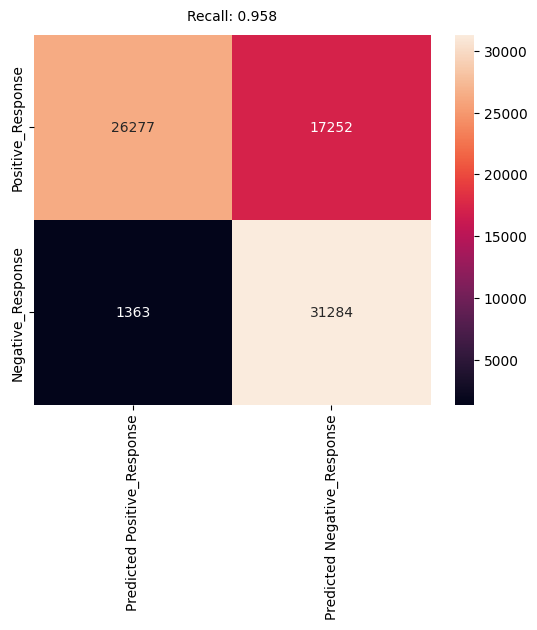

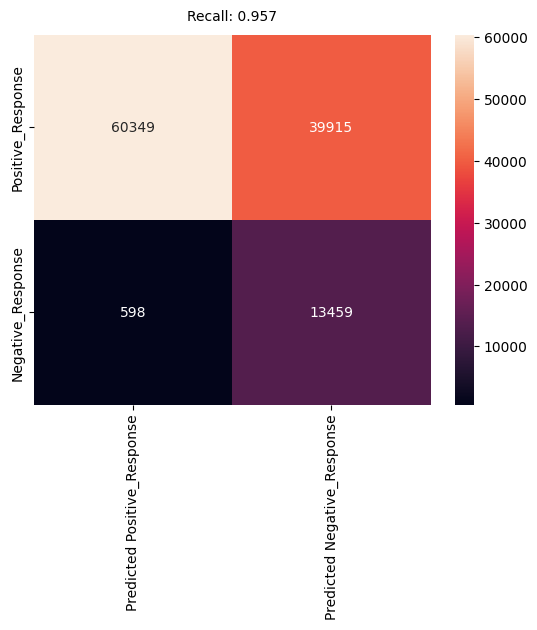

AUC Score (Train): 0.8313
AUC Score (Test): 0.8310


In [234]:
#Sviluppo modello di regressione logistica
def fun_logistic_regression(X_train, X_test, y_train, y_test, standardize=False, method=None, ratio=1.0):
    """
    Addestra un modello di regressione logistica con diverse opzioni per gestire i dati sbilanciati.

    Parametri:
    - X_train, X_test: Caratteristiche per l'addestramento e il test.
    - y_train, y_test: Etichette target per l'addestramento e il test.
    - standardize (bool): Se applicare o meno la standardizzazione alle caratteristiche.
    - method (str): Il metodo per gestire lo sbilanciamento delle classi. Le opzioni sono:
      - None: Nessuna modifica
      - 'class_weight': Applica i pesi alle classi
      - 'smote': Applica SMOTE per il sovracampionamento
      - 'undersample': Applica il sottocampionamento per bilanciare le classi
    - ratio (float): Il rapporto tra la classe minoritaria e quella maggioritaria nel ricampionamento.

    Restituisce:
    - lr: Modello di regressione logistica addestrato.
    - y_pred_train, y_pred_test: Predizioni sui set di addestramento e test.
    - y_proba_train, y_proba_test: Probabilità previste sui set di addestramento e test.
    """

    if standardize:
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)

    if method == 'class_weight':
        lr = LogisticRegression(class_weight="balanced", random_state=RANDOM_SEED)
    elif method == 'smote':
        smote = SMOTE(sampling_strategy=ratio, random_state=RANDOM_SEED)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        print(f"After SMOTE: {Counter(y_train)}")
        lr = LogisticRegression(random_state=RANDOM_SEED)
    elif method == 'undersample':
        rus = RandomUnderSampler(sampling_strategy=ratio, random_state=RANDOM_SEED)
        X_train, y_train = rus.fit_resample(X_train, y_train)
        print(f"After undersample: {Counter(y_train)}")
        lr = LogisticRegression(random_state=RANDOM_SEED)
    else:
        lr = LogisticRegression(random_state=RANDOM_SEED)

    lr.fit(X_train, y_train)

    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    y_proba_train = lr.predict_proba(X_train)
    y_proba_test = lr.predict_proba(X_test)

    print("TRAIN REPORT")
    classification_report(y_train, y_pred_train)
    print("TEST REPORT")
    classification_report(y_test, y_pred_test)

    # Matrice di confusione per il training set
    plot_confusion_matrix(y_train, y_pred_train, ["Positive_Response", "Negative_Response"])
    # Matrice di confusione per il test set
    plot_confusion_matrix(y_test, y_pred_test, ["Positive_Response", "Negative_Response"])

    # Calcolo dell'AUC
    auc_score_train = roc_auc_score(y_train, y_proba_train[:, 1])
    auc_score_test = roc_auc_score(y_test, y_proba_test[:, 1])
    print(f"AUC Score (Train): {auc_score_train:.4f}")
    print(f"AUC Score (Test): {auc_score_test:.4f}")

    # # Visualizzazione delle curve ROC
    # RocCurveDisplay.from_estimator(lr, X_train, y_train)
    # plt.show()
    # RocCurveDisplay.from_estimator(lr, X_test, y_test)
    # plt.show()

    return lr, y_pred_train, y_pred_test, y_proba_train, y_proba_test

#Funzione per rappresentre matrice di confusione
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_recall=True):
    """
        Funzione per tracciare la matrice di confusione con l'opzione di visualizzare la recall.
    """
    cm = confusion_matrix(y_true, y_pred)

    df_cm = pd.DataFrame(cm, index=labels, columns=["Predicted " + labels[0], "Predicted " + labels[1]])
    sns.heatmap(df_cm, annot=True, fmt='g')

    if show_recall:
        recall = cm[1][1] / (cm[1][1] + cm[1][0])
        plt.text(1, -0.1, f"Recall: {recall:.3f}", ha='center', va='center')
    plt.show()

#Funzione per leggere il report con tutte le metriche
def classification_report(y_true, y_pred):
    print(f"PRECISION: {precision_score(y_true, y_pred)}")
    print(f"RECALL: {recall_score(y_true, y_pred)}")
    print(f"F1: {f1_score(y_true, y_pred)}")
    print(f"ACCURACY: {accuracy_score(y_true, y_pred)}")

# Funzione con diversi metodi di bilanciamento per selezionarne il migliore
print('No transformation:')
lr_model, y_pred_train, y_pred_test, y_proba_train, y_proba_test = fun_logistic_regression(
    X_train, X_test, y_train, y_test, standardize=True, method=None)
print('----------------------------------------------------------------------------------------------')
print('Class weight:')
lr_model, y_pred_train, y_pred_test, y_proba_train, y_proba_test = fun_logistic_regression(
    X_train, X_test, y_train, y_test, standardize=True, method='class_weight')
print('----------------------------------------------------------------------------------------------')
print('Oversampling Ratio 1:')
lr_model, y_pred_train, y_pred_test, y_proba_train, y_proba_test = fun_logistic_regression(
    X_train, X_test, y_train, y_test, standardize=True, method='smote', ratio=1.0)
print('----------------------------------------------------------------------------------------------')
print('Undersampling Ratio 1:')
lr_model, y_pred_train, y_pred_test, y_proba_train, y_proba_test = fun_logistic_regression(
    X_train, X_test, y_train, y_test, standardize=True, method='undersample', ratio=1.0)
print('----------------------------------------------------------------------------------------------')
print('Oversampling Ratio 0.5:')
lr_model, y_pred_train, y_pred_test, y_proba_train, y_proba_test = fun_logistic_regression(
    X_train, X_test, y_train, y_test, standardize=True, method='smote', ratio=0.5)
print('----------------------------------------------------------------------------------------------')
print('Undersampling Ratio 0.5:')
lr_model, y_pred_train, y_pred_test, y_proba_train, y_proba_test = fun_logistic_regression(
    X_train, X_test, y_train, y_test, standardize=True, method='undersample', ratio=0.5)
print('----------------------------------------------------------------------------------------------')
print('Oversampling Ratio 0.75:')
lr_model, y_pred_train, y_pred_test, y_proba_train, y_proba_test = fun_logistic_regression(
    X_train, X_test, y_train, y_test, standardize=True, method='smote', ratio=0.75)
print('----------------------------------------------------------------------------------------------')
print('Undersampling Ratio 0.75:')
lr_model, y_pred_train, y_pred_test, y_proba_train, y_proba_test = fun_logistic_regression(
    X_train, X_test, y_train, y_test, standardize=True, method='undersample', ratio=0.75)

After undersample: Counter({0: 32647, 1: 32647})
TRAIN REPORT
PRECISION: 0.7057181469747658
RECALL: 0.975709866143903
F1: 0.8190373341561247
ACCURACY: 0.7844212331914111
TEST REPORT
PRECISION: 0.2508726721128717
RECALL: 0.976524151668208
F1: 0.39919155494809083
ACCURACY: 0.6385615941078192


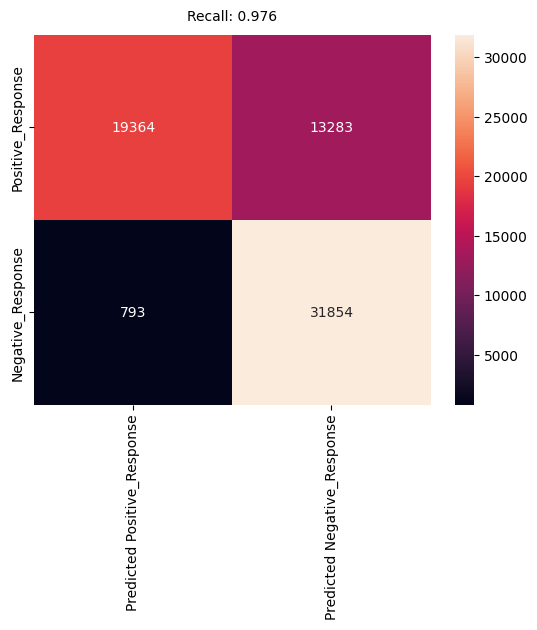

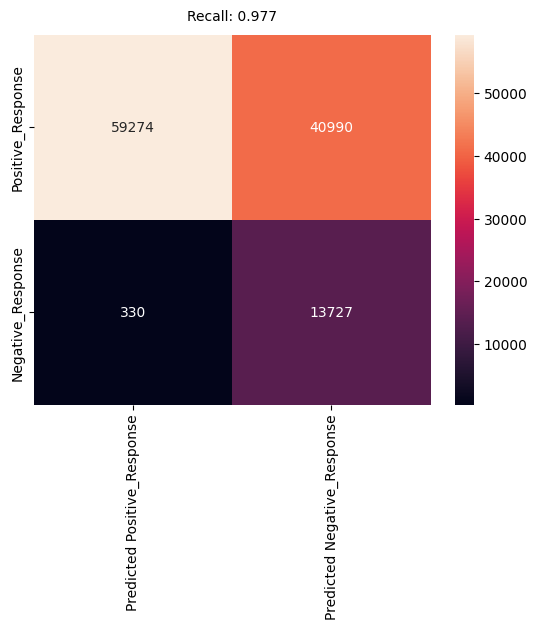

AUC Score (Train): 0.8315
AUC Score (Test): 0.8309


In [235]:
#Il risultato migliore per la Recall è 0.977 (nel test) relativo ad undersampling con ratio 1.
# Essendo il valore della recall molto simile tra train e test, si esclude la presenza di overfitting
lr_model, y_pred_train, y_pred_test, y_proba_train, y_proba_test = fun_logistic_regression(
    X_train, X_test, y_train, y_test, standardize=True, method='undersample', ratio=1)

In [236]:
#Calcolo probabilità 
ss = StandardScaler()
X_temp = ss.fit_transform(X_temp)
X_test_out_of_sample = ss.transform(X_test_out_of_sample)

In [237]:
y_proba = lr_model.predict_proba(X_test_out_of_sample)
condition = y_proba[:,1]>0.3
y_pred = np.where(condition,1,0)
y_proba = np.where(condition, y_proba[:, 1], y_proba[:, 0])
df_result = pd.DataFrame({
    "prediction":y_pred,
    "probability":y_proba.round(4),
    "true Response": y_test_out_of_sample
})

In [238]:
df_result.reset_index()

,index,prediction,probability,true Response
0,220145,0,0.9963,0
1,194704,1,0.6985,0
2,203625,1,0.6399,0
3,218048,1,0.8257,0
4,230458,0,0.9686,0
5,115334,1,0.7871,0
6,155444,1,0.8289,1
7,57192,1,0.7222,1
8,289488,0,0.7994,0
9,96039,1,0.3213,1


Conclusione: come si può vedere dal test out of sample, non ci sono casi in cui si prevede un valore errato per la classe minoritaria, quindi i clienti contattati che sono realmente interessati a comprare l'assicurazione auto vengono identificati con successo